In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from numpy.ma.core import count
from prompt_toolkit.key_binding.bindings.named_commands import yank_pop

warnings.filterwarnings('ignore')

In [2]:
bd = pd.read_csv('final.csv')

In [3]:
bd['finish_dttm'] = pd.to_datetime(bd['finish_dttm'])
bd['age'] = bd['age'].str.replace(',', '.').astype(float)

In [4]:
bd['flag'] = (bd['wo_hit_status_result_desc'] == 'Дозвон, Успешно')
bd['flag'] = bd['flag'].astype(int)
days_of_week = bd['finish_dttm'].dt.day_name()
days_of_week_num = bd['finish_dttm'].dt.weekday
bd['day_of_week'] = days_of_week
bd['num_of_week'] = days_of_week_num

In [5]:
def vibrosi(bd, i, x):
    return pd.concat([bd[bd[i] < x], bd[bd[i].isna()]])
def vibrosiVniz(bd, i, x):
    return pd.concat([bd[bd[i] > x], bd[bd[i].isna()]])

In [6]:
bd['child_flg'] = bd['child_amt'] != 0
bd['child_flg'] = bd['child_flg'].astype(int)

In [7]:
bd = vibrosi(bd, 'confirmed_income', 40000)
bd = vibrosi(bd, 'predicted_income', 45000)
bd = vibrosiVniz(bd, 'predicted_income', 0)
bd = vibrosiVniz(bd, 'age', 13)
# хочу делить по: age, auto_flg, partnership_flg, child_flg, realty_type, functional_cd, emp_work_months_cnt, emp_gender_cd, emp_age

In [8]:
df = bd.drop(bd[bd['wo_hit_status_reason_desc'].isin(['Отказ прослушать предложение', 'Не звонить', 'Левый контакт', 'Отказ от диалога', 'отказ от диалога', 'Отказ от разговора', 'Не звонить, резкий негатив', 'Негатив/Не звонить', 'Отказ без объяснения причин', 'просит не звонить', 'Не звонить / резкий негатив', 'Вежливо попросил не звонить', 'Номер не принадлежит страхователю', 'отказ без объяснения причин', 'Отказался озвучить причину', 'Чёрный список', 'негатив к Тинькофф', 'Грубо попросил не звонить', 'Не звонить (негатив)', 'Отказался от диалога', 'Просит больше не звонить', 'Недозвон', 'некорректная заявка', 'Техническая ошибка', 'Не нравится Т-Банк', 'Негатив к Т-Банку', 'Негативная информация о клиенте', 'Отказ без объяснения причины', 'Неизвестен / Не контактирует', 'Человек не участвовал в Дано', 'отменили'])].index)
# Создание нового столбца с логикой замещения NaN
df['income'] = df['confirmed_income'].fillna(df['predicted_income'])
df['segment_number'] = df['segment_cd'].str.extract(r'\((\d+)\)').astype(float)

In [9]:
df['num_segment'] = (df['segment_cd'].str[2:4])
df['num_segment'] = df['num_segment'].astype(float)

In [10]:
# Функция для определения сезона по номеру месяца
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    elif month in [9, 10, 11]:
        return 'Осень'

# Преобразуем finish_dttm в datetime, если нужно
df['finish_dttm'] = pd.to_datetime(df['finish_dttm'])

# Извлекаем номер месяца
df['month'] = df['finish_dttm'].dt.month

# Применяем функцию для создания нового столбца season
df['season'] = df['month'].apply(get_season)

In [33]:
df['finish_dttm']

AttributeError: 'Series' object has no attribute 'hours'

In [67]:
cl = df[df['product_cd'] == 'Cash Loan']

In [50]:
cl['wo_hit_status_reason_desc'].value_counts()

wo_hit_status_reason_desc
Кредит уже не нужен                                       758
Другое                                                    568
Отказ по всем продуктам                                   179
Не устраивает одобренная сумма                             96
Переведен в банк                                           79
Назначена встреча                                          79
Нет потребности в кредите                                  74
Высокая ставка по кредиту                                  68
Третье лицо                                                65
Отказ после БКИ                                            40
Согласовано без встречи                                    37
Другой банк                                                31
Нет потребности                                            29
Upsell на КНЗ                                              27
Другое (нестандартная ситуация)                            26
Активирует самостоятельно позднее           

In [69]:
import pandasql as ps

q1 = """
SELECT * FROM cl
WHERE "Unnamed: 0" NOT IN (
    SELECT "Unnamed: 0" FROM cl
    WHERE "wo_hit_status_reason_desc" IN (
        "Третье лицо", "Другое", "Другое (нестандартная ситуация)", 
        "Другой банк", "Некорректный трансфер", "Уже оставил заявку",
        "Действующий клиент", "Просто интересовался условиями", "Не соответствует по возрасту",
        "Взял кредит в другом банке", "Уже активировал кредит", 
        "В списке нет подходящей причины (укажи в комментариях)",
        "Кредит / КК в другом банке", "Черный список", "Не оставлял заявку"
    ) 
)
"""

cl = ps.sqldf(q1, locals())

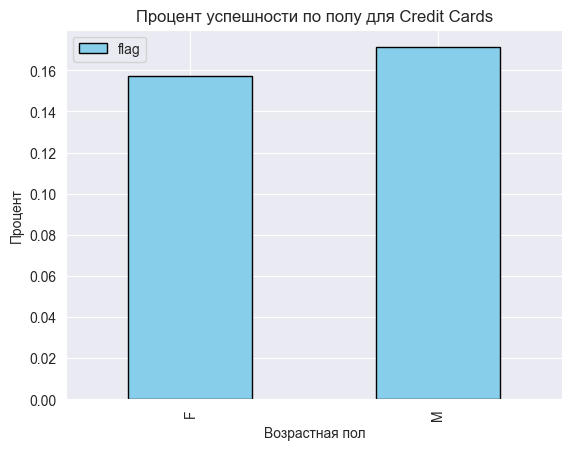

In [14]:
percent_by_gender = cl[['flag', 'gender_cd']].copy()
# percent_by_gender = percent_by_gender[np.isfinite(percent_by_gender['gender_cd'])]
percent_by_gender = percent_by_gender.groupby('gender_cd').mean()

ax = percent_by_gender.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Процент успешности по полу для Credit Cards")
plt.xlabel("Возрастная пол")
plt.ylabel("Процент")
plt.show()

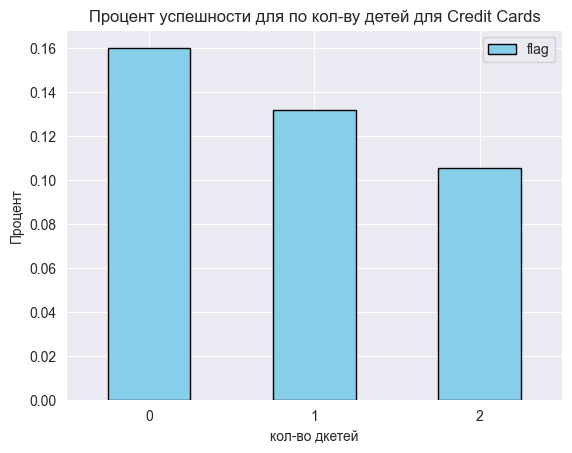

In [20]:
percent_by_child_cnt = cl[cl['child_amt'] < 3][['child_amt', 'flag']].copy()
percent_by_child_cnt = percent_by_child_cnt[np.isfinite(percent_by_child_cnt['child_amt'])]
percent_by_child_cnt = percent_by_child_cnt.groupby('child_amt').mean()

ax = percent_by_child_cnt.plot(kind='bar', color='skyblue', edgecolor='black')
labels = [0, 1, 2]
ax.set_xticklabels(labels, rotation=0)
plt.title("Процент успешности для по кол-ву детей для Credit Cards")
plt.xlabel("кол-во дкетей")
plt.ylabel("Процент")
plt.show()

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (7).

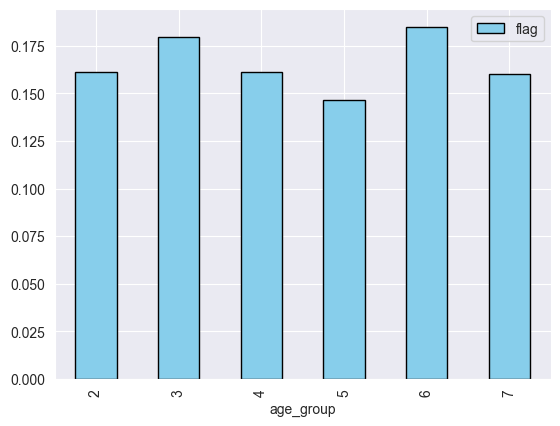

In [22]:
import math

def Anton(x, musthave, c):
    # Определяем k (для минимального числа) и n (для максимального числа)
    k = math.ceil((musthave - 14) / c)
    n = math.ceil((68 - musthave) / c)
    
    # Номер группы
    if x < musthave:  # Группы ниже musthave
        group = k - math.ceil((musthave - x) / c) + 1
    elif x >= musthave:  # Группы выше или равны musthave
        group = k + math.floor((x - musthave) / c) + 1
    
    return group


def Dima(musthave, c):
    import math
    
    # Определяем k и n
    k = math.ceil((musthave - 14) / c)
    n = math.ceil((71 - musthave) / c)
    
    # Массив групп
    groups = []
    for i in range(-(k - 2), n):  # От второй группы до предпоследней
        group_start = musthave + (i - 1) * c
        group_end = musthave + i * c - 1
        groups.append(f"{group_start}-{group_end}")
    
    # Числа начала второй группы и конца предпоследней
    second_group_start = musthave - (k - 1) * c
    penultimate_group_end = musthave + (n - 1) * c - 1
    
    return groups, second_group_start, penultimate_group_end

# Пример вызова функции
musthave = 45
c = 10
groups, second_start, penultimate_end = Dima(musthave, c)

percent_by_age = cl[cl['age'] <= 71][['age', 'flag']].copy()
percent_by_age = percent_by_age[np.isfinite(percent_by_age['age'])]
percent_by_age['age_group'] = percent_by_age['age'].apply(lambda x: Anton(x, musthave, c))
percent_by_age = percent_by_age[['age_group', 'flag']].groupby('age_group').mean()

ax = percent_by_age.plot(kind='bar', color='skyblue', edgecolor='black')
labels = groups
if second_start != 14:
    labels = [f'14-{second_start-1}'] + labels
if penultimate_end != 71:
    labels = labels + [f'{penultimate_end}+']
ax.set_xticklabels(labels, rotation=0)
plt.title("Процент успешности для возрастной группы для Credit Cards")
plt.xlabel("Возрастная группа")
plt.ylabel("Процент")
plt.show()

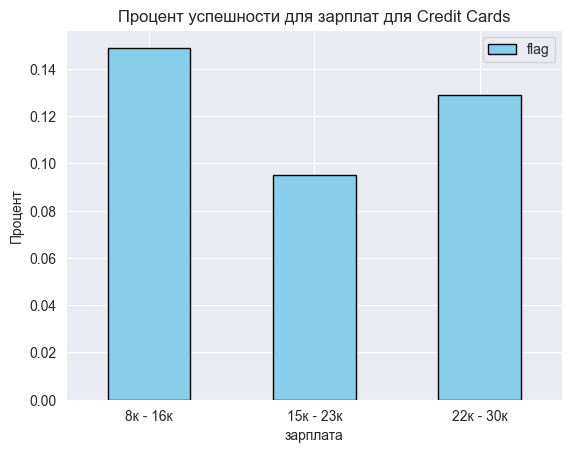

In [24]:
cl['income'] = cl['confirmed_income'].fillna(cl['predicted_income'])
percent_by_income = cl[cl['income'] < 28000][['flag', 'income']].copy()
percent_by_income = percent_by_income[np.isfinite(percent_by_income['income'])]
percent_by_income['income'] = (percent_by_income[percent_by_income['income'] > 8000]['income'] // 8000 * 8000).astype(int)
percent_by_income = percent_by_income.groupby('income').mean()

ax = percent_by_income.plot(kind='bar', color='skyblue', edgecolor='black')
labels = [(str(i) + 'к - ' + str(i+8) + 'к') for i in range(8, 28, 7)]
ax.set_xticklabels(labels, rotation=0)
plt.title("Процент успешности для зарплат для Credit Cards")
plt.xlabel("зарплата")
plt.ylabel("Процент")
plt.show()

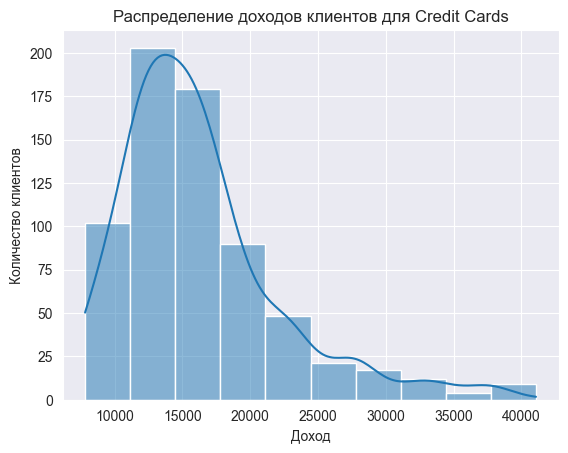

Средний доход: 16241.04
Медианный доход: 15033.50


In [26]:
# Гистограмма доходов
cl['income'] = cl['confirmed_income'].fillna(cl['predicted_income'])

sns.histplot(cl['income'], bins=10, kde=True)
plt.title('Распределение доходов клиентов для Credit Cards')
plt.xlabel('Доход')
plt.ylabel('Количество клиентов')
plt.show()

# Средняя и медианная зарплата
mean_income = cl['income'].mean()
median_income = cl['income'].median()

print(f"Средний доход: {mean_income:.2f}")
print(f"Медианный доход: {median_income:.2f}")


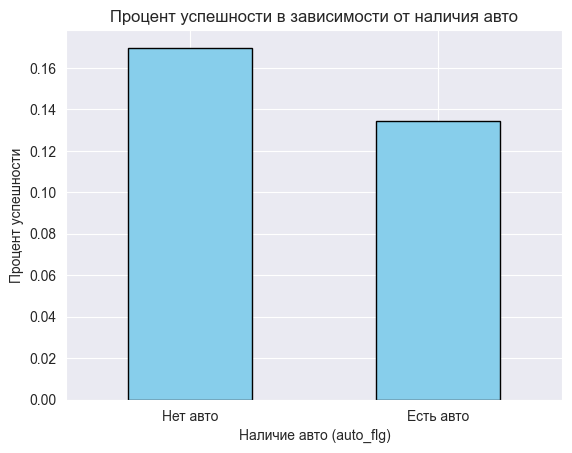

In [28]:
# Фильтрация данных и расчет среднего процента успешности по `auto_flg`
percent_by_auto = cl[['auto_flg', 'flag']].copy()
percent_by_auto = percent_by_auto.dropna(subset=['auto_flg'])  # Убираем NaN из auto_flg
percent_by_auto['auto_flg'] = percent_by_auto['auto_flg'].astype(int)  # Приведение к целому

# Группировка и расчет средней успешности
percent_by_auto = percent_by_auto.groupby('auto_flg').mean()

# Построение графика
ax = percent_by_auto.plot(kind='bar', color='skyblue', edgecolor='black', legend=False)
ax.set_xticklabels(['Нет авто', 'Есть авто'], rotation=0)
plt.title("Процент успешности в зависимости от наличия авто")
plt.xlabel("Наличие авто (auto_flg)")
plt.ylabel("Процент успешности")
plt.show()


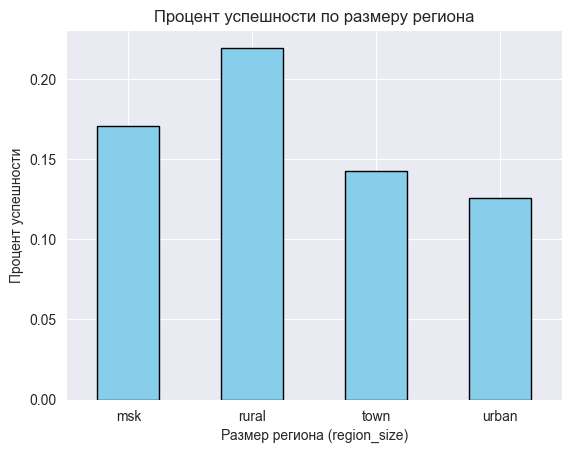

In [22]:
# Фильтрация данных и расчет среднего процента успешности по `region_size`
percent_by_region = cl[['region_size', 'flag']].copy()
percent_by_region = percent_by_region.dropna(subset=['region_size'])  # Убираем NaN из region_size

# Группировка и расчет средней успешности
percent_by_region = percent_by_region.groupby('region_size').mean()

# Построение графика
ax = percent_by_region.plot(kind='bar', color='skyblue', edgecolor='black', legend=False)
ax.set_xticklabels(percent_by_region.index, rotation=0)
plt.title("Процент успешности по размеру региона")
plt.xlabel("Размер региона (region_size)")
plt.ylabel("Процент успешности")
plt.show()


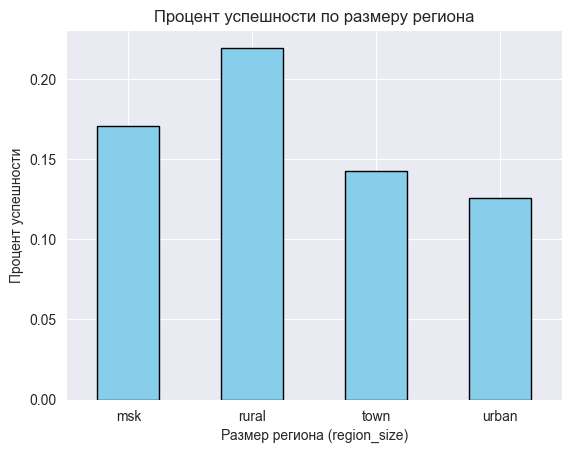

In [24]:
# Фильтрация данных и расчет среднего процента успешности по `region_size`
percent_by_region = cl[['region_size', 'flag']].copy()
percent_by_region = percent_by_region.dropna(subset=['region_size'])  # Убираем NaN из region_size

# Группировка и расчет средней успешности
percent_by_region = percent_by_region.groupby('region_size').mean()

# Построение графика
ax = percent_by_region.plot(kind='bar', color='skyblue', edgecolor='black', legend=False)
ax.set_xticklabels(percent_by_region.index, rotation=0)
plt.title("Процент успешности по размеру региона")
plt.xlabel("Размер региона (region_size)")
plt.ylabel("Процент успешности")
plt.show()


In [20]:
cl[cl['region_size'] == 'rural']

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,emp_marital_status_cd,flag,day_of_week,num_of_week,child_flg,income,segment_number,num_segment,month,season
2,273,304142124,23.0,M,rural,0.0,0.0,1.0,1.0,1.0,...,None,0,Monday,0,0,15283.50,7.0,2.0,1,Зима
15,2500,448716687,42.0,F,rural,0.0,0.0,0.0,0.0,1.0,...,None,1,Thursday,3,0,15808.33,6.0,1.0,1,Зима
16,2544,67918764,43.0,M,rural,0.0,0.0,1.0,0.0,1.0,...,Холост/не замужем,0,Wednesday,2,0,8360.78,20.0,3.0,8,Лето
30,4739,136089519,26.0,F,rural,0.0,1.0,0.0,0.0,1.0,...,None,0,Wednesday,2,0,15823.50,7.0,2.0,2,Зима
32,5380,309284298,34.0,M,rural,0.0,0.0,1.0,1.0,1.0,...,None,0,Monday,0,0,21665.78,7.0,2.0,1,Зима
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,17589,305526158,36.0,F,rural,0.0,1.0,0.0,0.0,1.0,...,Женат/замужем,0,Thursday,3,1,NaN,20.0,3.0,3,Весна
1630,18398,536787560,64.0,F,rural,0.0,0.0,1.0,0.0,1.0,...,None,0,Tuesday,1,0,NaN,24.0,5.0,1,Зима
1633,18431,478533773,36.0,F,rural,0.0,0.0,1.0,0.0,1.0,...,None,0,Thursday,3,1,NaN,20.0,3.0,1,Зима
1641,18506,259287709,36.0,M,rural,0.0,0.0,0.0,0.0,1.0,...,Холост/не замужем,0,Tuesday,1,1,NaN,20.0,3.0,11,Осень


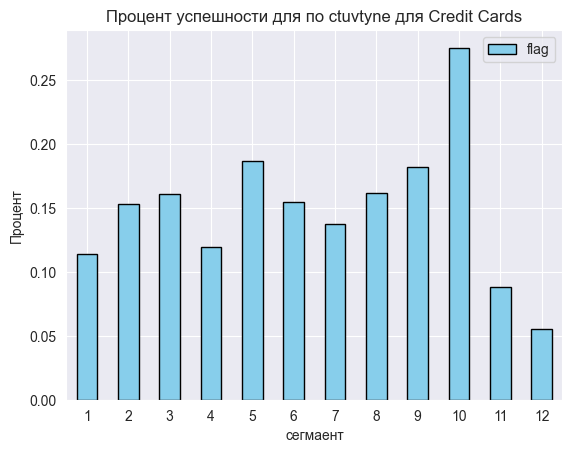

In [36]:
percent_by_child_cnt = cl[['num_segment', 'flag']].copy()
percent_by_child_cnt = percent_by_child_cnt[np.isfinite(percent_by_child_cnt['num_segment'])]
percent_by_child_cnt = percent_by_child_cnt.groupby('num_segment').mean()

ax = percent_by_child_cnt.plot(kind='bar', color='skyblue', edgecolor='black')
labels = [i for i in range(1, 13)]
ax.set_xticklabels(labels, rotation=0)
plt.title("Процент успешности для по ctuvtyne для Credit Cards")
plt.xlabel("сегмаент")
plt.ylabel("Процент")
plt.show()

In [60]:
print(f"процент успешности для сегментов <5 и >10: {round(cl[(cl['num_segment'] < 5) | (cl['num_segment'] > 10)]['flag'].mean()*100, 2)}%")

процент успешности для сегментов <5 и >10: 12.87%


In [68]:
print(f"процент успешности для сегментов >=5 и <=10: {round(cl[(cl['num_segment'] >= 5) & (cl['num_segment'] <= 10)]['flag'].mean()*100, 2)}%")

процент успешности для сегментов >=5 и <=10: 17.27%


In [71]:
# Функция для определения сезона по номеру месяца
def get_season(month):
    if month in [1, 2, 3, 4]:
        return '1-4'
    elif month in [5, 6, 7, 8, 9, 10]:
        return '5-10'
    elif month in [11, 12]:
        return '11-12'


cl['group_segment'] = cl['num_segment'].apply(get_season)

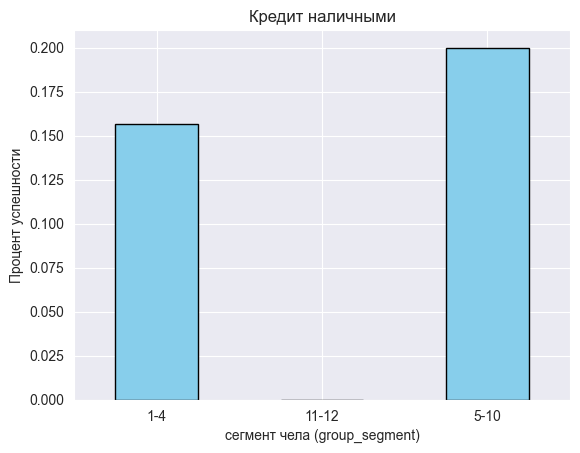

In [76]:
# Фильтрация данных и расчет среднего процента успешности по `region_size`
percent_by_region = cl[cl['region_size'] == 'msk'][['group_segment', 'flag']].copy()
percent_by_region = percent_by_region.dropna(subset=['group_segment'])  # Убираем NaN из region_size

# Группировка и расчет средней успешности
percent_by_region = percent_by_region.groupby('group_segment').mean()

# Построение графика
ax = percent_by_region.plot(kind='bar', color='skyblue', edgecolor='black', legend=False)
ax.set_xticklabels(percent_by_region.index, rotation=0)
plt.title("Кредит наличными")
plt.xlabel("сегмент чела (group_segment)")
plt.ylabel("Процент успешности")
plt.show()


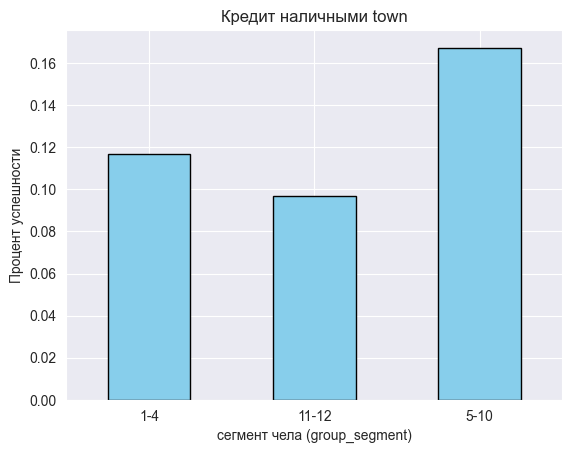

In [81]:
# Фильтрация данных и расчет среднего процента успешности по `region_size`
percent_by_region = cl[cl['region_size'] == 'town'][['group_segment', 'flag']].copy()
percent_by_region = percent_by_region.dropna(subset=['group_segment'])  # Убираем NaN из region_size

# Группировка и расчет средней успешности
percent_by_region = percent_by_region.groupby('group_segment').mean()

# Построение графика
ax = percent_by_region.plot(kind='bar', color='skyblue', edgecolor='black', legend=False)
ax.set_xticklabels(percent_by_region.index, rotation=0)
plt.title("Кредит наличными town")
plt.xlabel("сегмент чела (group_segment)")
plt.ylabel("Процент успешности")
plt.show()


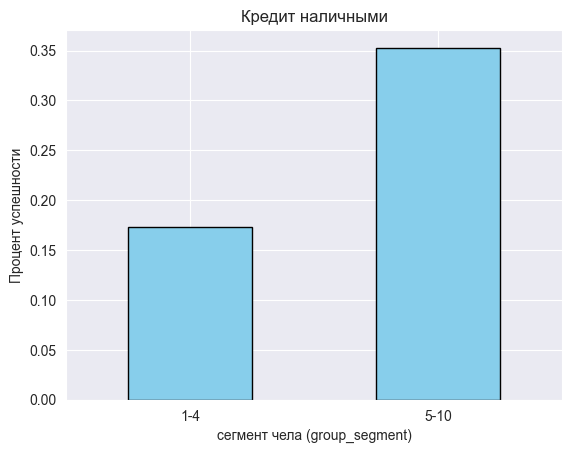

In [79]:
# Фильтрация данных и расчет среднего процента успешности по `region_size`
percent_by_region = cl[cl['region_size'] == 'rural'][['group_segment', 'flag']].copy()
percent_by_region = percent_by_region.dropna(subset=['group_segment'])  # Убираем NaN из region_size

# Группировка и расчет средней успешности
percent_by_region = percent_by_region.groupby('group_segment').mean()

# Построение графика
ax = percent_by_region.plot(kind='bar', color='skyblue', edgecolor='black', legend=False)
ax.set_xticklabels(percent_by_region.index, rotation=0)
plt.title("Кредит наличными")
plt.xlabel("сегмент чела (group_segment)")
plt.ylabel("Процент успешности")
plt.show()


In [90]:
cl[cl['segment_number'].isna()]['income']

21       8754.51
26      19323.50
29      19823.50
35      20823.50
47      12323.50
          ...   
1655         NaN
1656         NaN
1658         NaN
1659         NaN
1660         NaN
Name: income, Length: 325, dtype: float64

In [17]:
cl[['num_segment', 'flag']].groupby(by='num_segment').agg(['mean', 'count'])

flag      
                 mean count
num_segment                
1.0          0.113924   158
2.0          0.153285   137
3.0          0.160714   112
4.0          0.119816   217
5.0          0.186992   123
6.0          0.154472   123
7.0          0.137566   189
8.0          0.161765    68
9.0          0.181818    88
10.0         0.275362    69
11.0         0.088235    34
12.0         0.055556    18

In [157]:
def OAXAXXAXAXAXAX(x):
    # if x in [1, 2, 3]:
    #     return '1-3'
    # if x in [4, 5, 6]:
    #     return '4-6'
    # if x in [7, 8, 9]:
    #     return '7-9'
    # if x in [10, 11, 12]:
    #     return '9-12'
    if x in [5, 6, 7, 8, 9, 10]:
        return 1
    return 0

cl['group_segment'] = cl['num_segment'].apply(OAXAXXAXAXAXAX)
cl['segment_by_2'] = cl['num_segment'] // 2

In [158]:
cl[['group_segment', 'flag']].groupby('group_segment').agg(['mean', 'count'])

flag      
                   mean count
group_segment                
0              0.161838  1001
1              0.172727   660

In [96]:
cl_rural[['is_rural', 'flag']].groupby('is_rural').agg(['mean', 'count'])

flag      
              mean count
is_rural                
0         0.179161   787
1         0.154462   874

In [160]:
from scipy.stats import chi2_contingency

cl_rural = cl.copy()
contingency_table = pd.crosstab(cl_rural['group_segment'], cl_rural['flag'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Хи-квадрат:", chi2)
print("p-значение:", p)

if p < 0.05:
    print("Зависимость между segment_number и flag статистически значима.")
else:
    print("Зависимость между segment_number и flag не обнаружена.")

Хи-квадрат: 0.2663329262930003
p-значение: 0.605802352271788
Зависимость между segment_number и flag не обнаружена.


In [99]:
from scipy.stats import fisher_exact

# Таблица сопряженности
table = pd.crosstab(cl_rural['is_rural'], cl_rural['flag'])

# Точный тест Фишера
odds_ratio, p_value = fisher_exact(table)

print("Odds Ratio:", odds_ratio)
print("p-значение:", p_value)

if p_value < 0.05:
    print("Есть значимая зависимость между is_rural и flag.")
else:
    print("Значимой зависимости между is_rural и flag не обнаружено.")

Odds Ratio: 0.8369562087927908
p-значение: 0.1869747956668631
Значимой зависимости между is_rural и flag не обнаружено.


In [87]:
from scipy.stats import kruskal

# Группировка по segment_number
Xy = cl[['group_segment', 'flag']].dropna()

group1 = Xy[Xy['group_segment'] == '1-4']['flag']
group2 = Xy[Xy['group_segment'] == '5-8']['flag']
group3 = Xy[Xy['group_segment'] == '9-12']['flag']

# Критерий Краскала-Уоллиса
stat, p = kruskal(group1, group2, group3, group4)

print("Статистика критерия Краскала-Уоллиса:", stat)
print("p-значение:", p)

if p < 0.05:
    print("Есть значимые различия в успехе между группами segment_number.")
else:
    print("Значимых различий в успехе между группами нет.")

Статистика критерия Краскала-Уоллиса: 5.062804066958702
p-значение: 0.1672556651915069
Значимых различий в успехе между группами нет.


In [76]:
group1

0       0
2       0
6       0
7       0
9       0
       ..
1622    0
1633    0
1635    0
1641    0
1643    0
Name: flag, Length: 407, dtype: int64

In [56]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

Xy = cl[['segment_number', 'flag']].dropna()
X = Xy['segment_number']
y = Xy['flag']

model = LogisticRegression()
model.fit(X, y)

# Вывод результатов
print("Коэффициент segment_number:", model.coef_[0][0])
print("Интерцепт:", model.intercept_[0])

# Вывод вероятностей по сегментам
cl['predicted_prob'] = model.predict_proba(X)[:, 1]

# Средняя вероятность успеха для каждого сегмента
avg_prob_per_segment = cl.groupby('segment_number')['predicted_prob'].mean()
print("\nСредние вероятности успеха по сегментам:\n", avg_prob_per_segment)

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [101]:
ccc = df[df['product_cd'] == 'Credit Cards']

import pandasql as ps
q4 = """
SELECT * FROM ccc
WHERE "Unnamed: 0" NOT IN (
    SELECT "Unnamed: 0" FROM ccc
    WHERE "wo_hit_status_reason_desc" IN (
        "Третье лицо", "Другое", "Другой банк", "Карту навязали",
        "Заявку не оставлял", "Другое (нестандартная ситуация)",
        "Кредит / КК в другом банке", "Отказ предоставить персональные данные",
        "Другое (укажи в комментарии)", "Не соответствует по возрасту",
        "Пользуюсь другим антивирусом", "Некорректный трансфер"
    ) 
)
"""

cc_clients = ps.sqldf(q4, locals())

In [105]:
df[['region_size', 'flag']].groupby(by='region_size').agg(['mean', 'count'])

flag      
                 mean count
region_size                
msk          0.137349  1245
rural        0.201245   964
town         0.176725  5087
urban        0.146207  2175

In [103]:
ccc

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,emp_marital_status_cd,flag,day_of_week,num_of_week,child_flg,income,segment_number,num_segment,month,season
23,23,342879157,27.0,M,NaN,NaN,NaN,NaN,NaN,NaN,...,Холост/не замужем,0,Monday,0,1,20323.50,NaN,NaN,1,Зима
63,63,282407696,41.0,M,rural,0.0,1.0,1.0,0.0,1.0,...,Холост/не замужем,0,Saturday,5,0,15823.50,7.0,2.0,2,Зима
117,117,509469281,42.0,F,town,0.0,0.0,0.0,0.0,1.0,...,Холост/не замужем,0,Friday,4,1,13639.56,29.0,7.0,2,Зима
710,710,326663782,21.0,F,town,0.0,0.0,1.0,0.0,1.0,...,NaN,0,Thursday,3,0,12878.91,36.0,9.0,10,Осень
1178,1178,480706447,44.0,M,town,0.0,0.0,0.0,0.0,1.0,...,NaN,0,Friday,4,1,7984.12,16.0,4.0,8,Лето
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18077,18077,584331549,NaN,M,town,0.0,0.0,0.0,0.0,0.0,...,NaN,0,Wednesday,2,0,NaN,44.0,12.0,6,Лето
18110,18110,525669032,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,Thursday,3,1,NaN,NaN,NaN,9,Осень
18220,18220,539821879,NaN,NaN,msk,1.0,0.0,0.0,0.0,1.0,...,NaN,0,Thursday,3,0,NaN,26.0,10.0,1,Зима
18353,18353,476196896,NaN,NaN,urban,1.0,0.0,0.0,0.0,0.0,...,NaN,0,Sunday,6,0,NaN,27.0,7.0,12,Зима


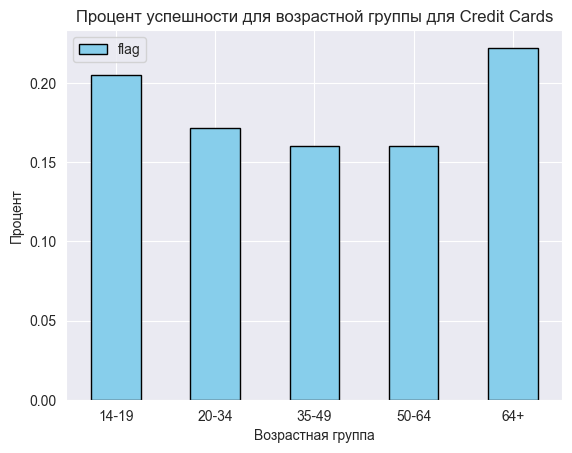

In [106]:
import math

def Anton(x, musthave, c):
    # Определяем k (для минимального числа) и n (для максимального числа)
    k = math.ceil((musthave - 14) / c)
    n = math.ceil((68 - musthave) / c)
    
    # Номер группы
    if x < musthave:  # Группы ниже musthave
        group = k - math.ceil((musthave - x) / c) + 1
    elif x >= musthave:  # Группы выше или равны musthave
        group = k + math.floor((x - musthave) / c) + 1
    
    return group


def Dima(musthave, c):
    import math
    
    # Определяем k и n
    k = math.ceil((musthave - 14) / c)
    n = math.ceil((68 - musthave) / c)
    
    # Массив групп
    groups = []
    for i in range(-(k - 2), n):  # От второй группы до предпоследней
        group_start = musthave + (i - 1) * c
        group_end = musthave + i * c - 1
        groups.append(f"{group_start}-{group_end}")
    
    # Числа начала второй группы и конца предпоследней
    second_group_start = musthave - (k - 1) * c
    penultimate_group_end = musthave + (n - 1) * c - 1
    
    return groups, second_group_start, penultimate_group_end

# Пример вызова функции
musthave = 35
c = 15
groups, second_start, penultimate_end = Dima(musthave, c)

percent_by_age = cl[cl['age'] <= 68][['age', 'flag']].copy()
percent_by_age = percent_by_age[np.isfinite(percent_by_age['age'])]
percent_by_age['age_group'] = percent_by_age['age'].apply(lambda x: Anton(x, musthave, c))
percent_by_age = percent_by_age[['age_group', 'flag']].groupby('age_group').mean()

ax = percent_by_age.plot(kind='bar', color='skyblue', edgecolor='black')
labels = groups
if second_start != 14:
    labels = [f'14-{second_start-1}'] + labels
if penultimate_end != 71:
    labels = labels + [f'{penultimate_end}+']
ax.set_xticklabels(labels, rotation=0)
plt.title("Процент успешности для возрастной группы для Credit Cards")
plt.xlabel("Возрастная группа")
plt.ylabel("Процент")
plt.show()

In [107]:
df['product_cd'].value_counts()

product_cd
Credit Cards          7401
Cash Loan             2402
MVNO                  1652
Debit Cards           1529
Investment             565
Secured Loan           435
Casco                  291
Mortgage Insurance     246
Car Loan               237
Osago                   23
Deposit                  8
Travel Avia              5
T-Auto                   2
Name: count, dtype: int64

In [167]:
def Anton(x, musthave, c):
    # Определяем k (для минимального числа) и n (для максимального числа)
    k = math.ceil((musthave - 14) / c)
    n = math.ceil((68 - musthave) / c)
    
    # Номер группы
    if x < musthave:  # Группы ниже musthave
        group = k - math.ceil((musthave - x) / c) + 1
    elif x >= musthave:  # Группы выше или равны musthave
        group = k + math.floor((x - musthave) / c) + 1
    
    return group


def Dima(musthave, c):
    import math
    
    # Определяем k и n
    k = math.ceil((musthave - 14) / c)
    n = math.ceil((68 - musthave) / c)
    
    # Массив групп
    groups = []
    for i in range(-(k - 2), n):  # От второй группы до предпоследней
        group_start = musthave + (i - 1) * c
        group_end = musthave + i * c - 1
        groups.append(f"{group_start}-{group_end}")
    
    # Числа начала второй группы и конца предпоследней
    second_group_start = musthave - (k - 1) * c
    penultimate_group_end = musthave + (n - 1) * c - 1
    
    return groups, second_group_start, penultimate_group_end

def da(cl):
    musthave = 35
    c = 10
    groups, second_start, penultimate_end = Dima(musthave, c)
    
    percent_by_age = cl[cl['age'] <= 68][['age', 'flag']].copy()
    percent_by_age = percent_by_age[np.isfinite(percent_by_age['age'])]
    percent_by_age['age_group'] = percent_by_age['age'].apply(lambda x: Anton(x, musthave, c))
    percent_by_age = percent_by_age[['age_group', 'flag']].groupby('age_group').mean()
    
    ax = percent_by_age.plot(kind='bar', color='skyblue', edgecolor='black')
    labels = groups
    if second_start != 14:
        labels = [f'14-{second_start-1}'] + labels
    if penultimate_end != 71:
        labels = labels + [f'{penultimate_end}+']
    ax.set_xticklabels(labels, rotation=0)
    plt.title("Процент успешности для возрастной группы для Credit Cards")
    plt.xlabel("Возрастная группа")
    plt.ylabel("Процент")
    plt.show()

In [142]:
df.functional_cd.value_counts()

functional_cd
Preapprove       6797
Afterfilling     1899
Utilization      1319
Upsell           1225
Cold             1131
Meeting           995
Agreement         486
Incoming          353
Downsell          198
Reutilization     171
Activation         85
BAF                52
Prolongation       46
Autoleads          30
Deposit             8
Refinancing         1
Name: count, dtype: int64

In [145]:
df[df['functional_cd'] == 'Upsell'][['flag', 'region_size']].groupby(by='region_size').agg(['mean', 'count'])

flag      
                 mean count
region_size                
msk          0.097826    92
rural        0.104000   125
town         0.085343   539
urban        0.056995   193

In [146]:
from scipy.stats import chi2_contingency

cl_rural = df[df['5'] != 'rural'][df['functional_cd'] == 'Upsell']
cl_rural['is_msk'] = (cl_rural['region_size'].isin(['msk'])).astype(int)
contingency_table = pd.crosstab(cl_rural['is_msk'], cl_rural['flag'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Хи-квадрат:", chi2)
print("p-значение:", p)

if p < 0.05:
    print("Зависимость между segment_number и flag статистически значима.")
else:
    print("Зависимость между segment_number и flag не обнаружена.")

Хи-квадрат: 0.14939910571457407
p-значение: 0.6991102569487428
Зависимость между segment_number и flag не обнаружена.


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (7).

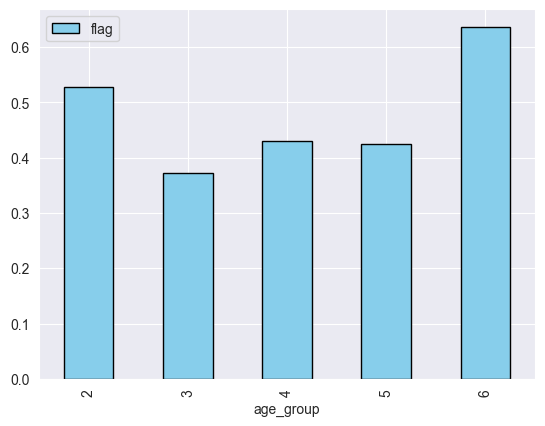

In [168]:
da(upsell)

In [204]:
upsell['wo_hit_status_reason_desc'].value_counts()

wo_hit_status_reason_desc
Не устраивает одобренная сумма                57
Назначена встреча                             50
Upsell на КНЗ                                 28
Высокая ставка по кредиту                     27
Не устраивает ни одно предложение             15
Клиент ранее отказался                        15
Нет недвижимости для залога                   12
Upsell на КНА                                  8
Отказ от кредита                               8
Дозаполнение заявки                            7
Нет квартиры для залога                        7
Без встречи                                    6
Отказ предоставлять недвижимость под залог     5
Без встречи, активация кредита                 4
Нет авто для залога                            3
Name: count, dtype: int64

In [213]:
import pandasql as ps

upsell = df[df['functional_cd'] == 'Upsell']
upsell = upsell.reset_index()

q1 = """
SELECT * FROM upsell 
WHERE "index" NOT IN (
    SELECT "index" 
    FROM upsell 
    WHERE wo_hit_status_reason_desc IN (
        'Кредит уже не нужен', 'Другое', 'Отказ по всем продуктам', 
        'Третье лицо', 'Клиент ранее отказался'
    )
)
"""
upsell = ps.sqldf(q1, locals())

In [244]:
def OAXAXXAXAXAXAX(x):
    # if x in [1, 2, 3]:
    #     return '1-3'
    # if x in [4, 5, 6]:
    #     return '4-6'
    # if x in [7, 8, 9]:
    #     return '7-9'
    # if x in [10, 11, 12]:
    #     return '9-12'
    if x in [4, 5, 6, 7, 8, 9, 10, 11, 12]:
        return 1
    return 0

upsell['group_segment'] = upsell['num_segment'].apply(OAXAXXAXAXAXAX)

In [245]:
upsell['num_segment'] = (upsell['segment_cd'].str[2:4])
upsell['num_segment'] = upsell['num_segment'].astype(float)
upsell[['flag', 'group_segment']].groupby(by='group_segment').agg(['mean', 'count'])

flag      
                   mean count
group_segment                
0              0.333333   138
1              0.463415   123

In [246]:
from scipy.stats import chi2_contingency

cl_rural = upsell.copy()
contingency_table = pd.crosstab(upsell['group_segment'], upsell['flag'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Хи-квадрат:", chi2)
print("p-значение:", p)

if p < 0.05:
    print("Зависимость между group_segment и flag статистически значима.")
else:
    print("Зависимость между group_segment и flag не обнаружена.")

Хи-квадрат: 4.077970340175294
p-значение: 0.04344581634691718
Зависимость между group_segment и flag статистически значима.


In [247]:
upsell['group_segment'].value_counts()

group_segment
0    138
1    123
Name: count, dtype: int64

In [226]:
df[['region_size', 'income']].groupby(by='region_size').agg(['mean', 'count'])

income      
                     mean count
region_size                    
msk          18397.303091   372
rural        15110.911561   378
town         15202.906127  1699
urban        15802.967398   757

In [229]:
df_income_by_segment = df[['num_segment', 'income']].groupby(by='num_segment').agg(['mean', 'count'])

In [232]:
df[df['functional_cd'] == 'Incoming']

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,emp_marital_status_cd,flag,day_of_week,num_of_week,child_flg,income,segment_number,num_segment,month,season
11330,11330,279255316,21.0,F,rural,0.0,0.0,0.0,0.0,1.0,...,NaN,0,Friday,4,0,16312.86,7.0,2.0,10,Осень
18441,18441,337771365,43.0,M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,Wednesday,2,1,7823.50,NaN,NaN,2,Зима
532,532,82192736,28.0,M,rural,0.0,0.0,0.0,0.0,1.0,...,NaN,1,Thursday,3,0,24823.50,7.0,2.0,10,Осень
928,928,528349431,33.0,F,urban,0.0,1.0,1.0,0.0,1.0,...,Холост/не замужем,0,Wednesday,2,0,14969.96,5.0,2.0,11,Осень
1106,1106,70440857,36.0,M,rural,0.0,0.0,1.0,0.0,0.0,...,NaN,0,Friday,4,0,18823.50,20.0,3.0,5,Весна
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10542,10542,423009425,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,Sunday,6,1,NaN,NaN,NaN,12,Зима
15497,15497,393622713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,Sunday,6,1,NaN,NaN,NaN,7,Лето
15641,15641,476402357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,Monday,0,1,NaN,NaN,NaN,1,Зима
16340,16340,498328418,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,Thursday,3,1,NaN,NaN,NaN,4,Весна


In [248]:
df['product_cd'].value_counts()

product_cd
Credit Cards          7401
Cash Loan             2402
MVNO                  1652
Debit Cards           1529
Investment             565
Secured Loan           435
Casco                  291
Mortgage Insurance     246
Car Loan               237
Osago                   23
Deposit                  8
Travel Avia              5
T-Auto                   2
Name: count, dtype: int64

In [249]:
ccc

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,emp_marital_status_cd,flag,day_of_week,num_of_week,child_flg,income,segment_number,num_segment,month,season
23,23,342879157,27.0,M,NaN,NaN,NaN,NaN,NaN,NaN,...,Холост/не замужем,0,Monday,0,1,20323.50,NaN,NaN,1,Зима
63,63,282407696,41.0,M,rural,0.0,1.0,1.0,0.0,1.0,...,Холост/не замужем,0,Saturday,5,0,15823.50,7.0,2.0,2,Зима
117,117,509469281,42.0,F,town,0.0,0.0,0.0,0.0,1.0,...,Холост/не замужем,0,Friday,4,1,13639.56,29.0,7.0,2,Зима
710,710,326663782,21.0,F,town,0.0,0.0,1.0,0.0,1.0,...,NaN,0,Thursday,3,0,12878.91,36.0,9.0,10,Осень
1178,1178,480706447,44.0,M,town,0.0,0.0,0.0,0.0,1.0,...,NaN,0,Friday,4,1,7984.12,16.0,4.0,8,Лето
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18077,18077,584331549,NaN,M,town,0.0,0.0,0.0,0.0,0.0,...,NaN,0,Wednesday,2,0,NaN,44.0,12.0,6,Лето
18110,18110,525669032,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,Thursday,3,1,NaN,NaN,NaN,9,Осень
18220,18220,539821879,NaN,NaN,msk,1.0,0.0,0.0,0.0,1.0,...,NaN,0,Thursday,3,0,NaN,26.0,10.0,1,Зима
18353,18353,476196896,NaN,NaN,urban,1.0,0.0,0.0,0.0,0.0,...,NaN,0,Sunday,6,0,NaN,27.0,7.0,12,Зима


In [250]:
ccc['wo_hit_status_reason_desc'].value_counts()

wo_hit_status_reason_desc
Кредитная карта не нужна                                      3864
Кредит уже не нужен                                            756
Третье лицо                                                    499
Назначена встреча                                              493
Другое                                                         270
                                                              ... 
Не выполню условия Premium                                       1
Интересна агентская сеть, будет пользоваться POS-кредитами       1
Перезвонит самостоятельно                                        1
Карту навязали                                                   1
Экстра-оффер                                                     1
Name: count, Length: 68, dtype: int64

In [251]:
cl[cl['region_size'] == 'msk'][['num_segment', 'flag']].groupby(by='num_segment').mean()

,flag
num_segment,
1.0,0.083333
2.0,0.208333
3.0,0.250000
4.0,0.096774
5.0,0.250000
6.0,0.300000
7.0,0.214286
8.0,0.125000
9.0,0.333333
